In [1]:
#import statements
import os
import pandas as pd
import numpy as np
from pathlib import Path

# Load the SDK
from lyft_dataset_sdk.lyftdataset import LyftDataset, LyftDatasetExplorer, Quaternion, view_points
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud

In [2]:
#hard links
!ln -s ./input/3d-object-detection-for-autonomous-vehicles/train_images ./input/3d-object-detection-for-autonomous-vehicles/images
!ln -s ./input/3d-object-detection-for-autonomous-vehicles/train_data ./input/3d-object-detection-for-autonomous-vehicles/data

ln: ./input/3d-object-detection-for-autonomous-vehicles/images: File exists
ln: ./input/3d-object-detection-for-autonomous-vehicles/data: File exists


In [3]:
#define lyftdata
path_tmp = "./input/3d-object-detection-for-autonomous-vehicles/"
lyftdata = LyftDataset(data_path=path_tmp, json_path=path_tmp+"train_data", verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 9.5 seconds.
Reverse indexing ...
Done reverse indexing in 3.1 seconds.


In [4]:
# helper function for segmenting points out of bounding box
def point_in_box(box, point):
    points = point.reshape((-1, 3, 1))

    corners = box.corners()

    p1 = corners[:, 0]
    p_x = corners[:, 4]
    p_y = corners[:, 1]
    p_z = corners[:, 3]

    i = p_x - p1
    j = p_y - p1
    k = p_z - p1
    
    modified_p1 = np.tile(p1.reshape(-1, 3, 1), (point.shape[0], 1, 1))
    v = points - modified_p1

    iv = np.dot(i, v)
    jv = np.dot(j, v)
    kv = np.dot(k, v)

    mask_x = np.logical_and(0 <= iv, iv <= np.dot(i, i))
    mask_y = np.logical_and(0 <= jv, jv <= np.dot(j, j))
    mask_z = np.logical_and(0 <= kv, kv <= np.dot(k, k))
    mask = np.logical_and(np.logical_and(mask_x, mask_y), mask_z)
    
    return mask[:, 0]

In [5]:
import random

#this function down samples and upsamples
#for upsampling, it adds noise to copies of points
#for down sampling, it samples points at even probability 
def getConsistentDimensions(mylist, sigma, dim=1024):
    length = len(mylist)

    if length > dim:
        res = np.array(random.sample(list(mylist), k=dim))
    else:
        res = mylist
        times = dim - len(mylist)
        
        resTwo = np.random.choice(len(mylist), size=times, replace=True)
        subset = mylist[resTwo]
        noise = sigma * np.random.randn(times, 3)
        try:
            res = np.concatenate((res, subset+noise), axis=0) 
        except:
            res = np.concatenate((list(res), resTwo+noise), axis=0) 
    return res

In [6]:
#example of a lookup using lyft SDK lookup
cat_token = lyftdata.category[0]['token']
lyftdata.get('category', cat_token)
lyftdata.sample_annotation[0]
lyftdata.get('attribute', lyftdata.sample_annotation[0]['attribute_tokens'][0])

{'description': '',
 'token': '1ba8c9a8bda54423fa710b0af1441d849ecca8ed7b7f9393ba1794afe4aa6aa2',
 'name': 'object_action_stopped'}

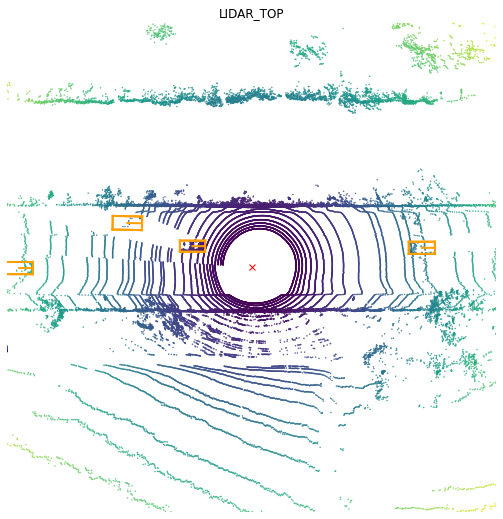

In [12]:
#visual scene lidar view
my_scene = lyftdata.scene[10]
my_sample_token = my_scene["first_sample_token"]
my_sample = lyftdata.get('sample', my_sample_token)
lyftdata.render_sample_data(my_sample['data']['LIDAR_TOP'], nsweeps=5)

In [24]:
#iterates through every pointcloud 
#segments out every object in pointcloud and labels it
#saves information locally that will be used later in preprocessing step 2
def getData(scene_number):
    scene_record = lyftdata.scene[scene_number]
    a = scene_record['token']
    last_token = lyftdata.get('sample', scene_record['last_sample_token'])

    # next_record = lyftdata.get('sample', sample_record['next'])
    my_sample = lyftdata.get('sample', scene_record['first_sample_token'])
    sample_data = lyftdata.get("sample_data", my_sample["data"]['LIDAR_TOP'])

    first_token = scene_record['first_sample_token']
    sample_record = lyftdata.get('sample', first_token)
    current_sample_token = scene_record['first_sample_token']

    try:
        os.mkdir("./data/" + str(scene_number))
    except:
        pass

    while current_sample_token != '':

        sample_record = lyftdata.get('sample', current_sample_token)
        sample_data = lyftdata.get("sample_data", sample_record["data"]['LIDAR_TOP'])

        pc = LidarPointCloud.from_file(lyftdata.data_path / sample_data["filename"])

        _, boxes, _ = lyftdata.get_sample_data(my_sample["data"]['LIDAR_TOP'], flat_vehicle_coordinates=False)

        only_points = pc.points[:3,:].T
    #     only_points.shape

        parent_dir = "./data/" + str(scene_number)
        dir_name = str(current_sample_token) + 'hi'
        path = os.path.join(parent_dir, dir_name)
        try:
            os.mkdir(path)
        except:
            pass
        for i, box in enumerate(boxes):
            mask = point_in_box(box, only_points)
            pointsBox  = only_points[mask]        
            if len(pointsBox) < 10:
                continue
            np.savetxt(path + "/" + box.name + "_" + str(i) + ".csv", pointsBox, delimiter=",")
        current_record = lyftdata.get('sample', current_sample_token)
        current_sample_token = current_record['next']